In [1]:
import itertools

import pandas as pd
import nimfa
import scipy
from timeit import default_timer as timer

from sklearn.cluster import KMeans

from hawkes.cluster import FormatAndSplit, ToSparse, GetClosestCustomers
from hawkes.utils import GetTimeSeriesFromDF, GetInfluenceMatrix
from hawkes.hawkes import ExpectationMaximization, Q

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv')

/Users/arnaud/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_df, train_coo, test_df, test_coo, ticker_idx = FormatAndSplit(df, cut_date=pd.to_datetime('20131231', format='%Y%m%d'))

In [24]:
ranks = [2, 3, 4, 5, 6, 7, 8, 9, 10]

def plop(rank, k=100, ntries=1):
    
    print rank
    scores = []
    for i in range(ntries):

        #### TRAIN

        # Clustering model
        cust = GetClosestCustomers(ticker_idx['GAZPRU'], train_coo, rank=rank)
        print "Customers closest to GAZPRU: %s" % cust

        idx = [c in cust for c in train_df['Customer']]
        dd = train_df.ix[idx, :]
        print "Train set after filtering: %s" % str(dd.shape)

        # Leader-Follower model
        train_time, train_mark = GetTimeSeriesFromDF(dd)
        mu, a, b, p = ExpectationMaximization(train_time, niter=100)

        customer_ids = train_mark["Customer"].values
        g, unique_ids = GetInfluenceMatrix(p, customer_ids)

        #### TEST

        idx = [c in cust for c in test_df['Customer']]
        dd = test_df.ix[idx, :]
        print "Test set after filtering: %s" % str(dd.shape)

        test_time, test_mark = GetTimeSeriesFromDF(dd)

        gg = g.copy()
        threshold = 0.01
        gg[gg < threshold] = 0
        print "Number of strong inluencers: %s" % sum(gg > 0)

        influencer_dict = dict((unique_ids[i], unique_ids[l]) for i, l in enumerate(scipy.sparse.lil_matrix(gg).rows) if l != [])

        customer_ids_test = test_mark["Customer"].values

        tpr = 0
        fpr = 0
        m = 0
        for influencer, influencee in influencer_dict.iteritems():
            for i in np.where(customer_ids_test == influencer)[0]:
                m += 1
                tpr += sum(j in influencee for j in customer_ids_test[i: i + k]) / float(k)
                fpr += (k - sum(j in influencee for j in customer_ids_test[i: i + k])) / float(k)

        if m > 0:
            tpr /= m
            fpr /= m
            scores.append(tpr)
        else:
            scores.append(None)
    return scores

In [ ]:
s = defaultdict(list)

In [29]:
from collections import defaultdict

for rank in [25, 30, 35, 40, 45, 50]:
    s[rank] = plop(rank=rank, k=100, ntries=5)

25
Customers closest to GAZPRU: [ 527  901  992 1052 1140  222  275 1218  686  691  916  942  433  202  601
  351    7  126 1075  286]
Train set after filtering: (7892, 58)
Test set after filtering: (15127, 58)
Number of strong inluencers: 1
Customers closest to GAZPRU: [ 992  686 1052  249  351  371  569 1075   43  499 1076  346  397  330  126
  155  609   51  749  662]
Train set after filtering: (5191, 58)
Test set after filtering: (11276, 58)
Number of strong inluencers: 2
Customers closest to GAZPRU: [ 126 1052  202  686  155  410  472  992  569  901  527 1076  609 1075 1241
  916   51  422  918  275]
Train set after filtering: (4074, 58)
Test set after filtering: (7903, 58)
Number of strong inluencers: 1
Customers closest to GAZPRU: [  43  351 1005  992  249  569  686  422  749  307  346 1075 1218  635 1254
  868  371 1076  275  125]
Train set after filtering: (4134, 58)
Test set after filtering: (7625, 58)
Number of strong inluencers: 3
Customers closest to GAZPRU: [ 617  543   7

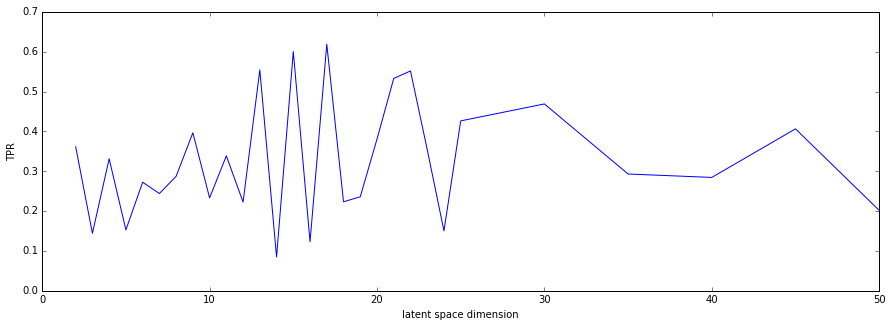

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(pd.DataFrame(s).describe().ix['mean', :])
plt.xlabel('latent space dimension')
plt.ylabel('TPR')
plt.show()

In [19]:
pd.DataFrame(s)

,2,3,4,5,6,7,8,9
0,0.571379,0.032795,0.066957,0.038160,0.115217,NaN,0.760996,0.798780
1,0.029820,0.383600,0.235951,0.098261,0.389486,NaN,0.316849,0.028529
2,0.450943,0.108755,0.572931,0.572931,0.312706,0.472644,NaN,0.265105
3,0.153778,0.166440,0.744739,0.017255,NaN,0.111739,0.041401,NaN
4,0.600864,0.029492,0.036000,0.037446,NaN,0.147621,0.030047,0.493610


In [23]:
from joblib import Parallel, delayed

In [ ]:
Parallel(n_jobs=5)(plop(rank=i) for i in range(2, 10))

Cluster closest to GAZPRU: set([577, 674, 1284, 906, 737, 268, 1002, 492, 205, 14, 612, 212, 698, 482, 932, 314, 763, 957, 1028, 415])
Train set after filtering: (5614, 58)
Test set after filtering: (9141, 58)
Number of strong inluencers: 1
Cluster closest to GAZPRU: set([577, 674, 1028, 815, 673, 1002, 875, 492, 482, 14, 751, 612, 1170, 275, 212, 398, 1284, 698, 932, 906])
Train set after filtering: (4649, 58)
Test set after filtering: (8526, 58)
Number of strong inluencers: 3
Cluster closest to GAZPRU: set([673, 259, 1028, 1061, 1284, 577, 268, 1002, 875, 492, 205, 14, 815, 1170, 212, 612, 698, 763, 906, 751])
Train set after filtering: (5211, 58)
Test set after filtering: (9057, 58)
Number of strong inluencers: 6
Cluster closest to GAZPRU: set([577, 674, 1028, 673, 314, 1002, 492, 482, 14, 751, 612, 1170, 275, 212, 398, 1284, 698, 932, 957, 415])
Train set after filtering: (5190, 58)
Test set after filtering: (8869, 58)
Number of strong inluencers: 1
Cluster closest to GAZPRU: set([